In [129]:
import skrub
from pathlib import Path
import pandas as pd
import sys
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate
from skrub import tabular_learner
from skrub import TableVectorizer
from datetime import datetime
import os
import json
import re 
import seaborn as sns

sys.path.append('/Users/alina/Desktop/MIT/code/ADHD/MTA/helper')
from helper import rr, prep, var_dict, audit, plot

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
if Path('/Volumes/Samsung_T5/MIT/mta').exists():
    data_root =     '/Volumes/Samsung_T5/MIT/mta'
    data_derived  = '/Volumes/Samsung_T5/MIT/mta/output/derived_data'
else: 
    data_root = '/Users/alina/Desktop/MIT/code/data'
    data_derived  = '/Users/alina/Desktop/MIT/code/data/output/derived_data'
    baseline_path = (Path(data_derived, 'baseline_data_prea'))
#os.listdir(data_root)

In [ ]:
info_path = Path(data_root, "files")
treat_group_file = 'treatment_groups.csv'
trt_names = pd.read_csv(Path(data_derived, treat_group_file))

['_wiat.csv',
 'expect_baseline_data_prea.csv',
 'masc_baseline_data_prea.csv',
 'snap_baseline_data_prea.csv',
 '_snap.csv',
 'wiat_baseline_data_prea.csv',
 'demgr_baseline_data_prea.csv',
 '_ssrs.csv',
 '_pcrc.csv',
 'cisp_baseline_data_prea.csv',
 '_cisp.csv',
 'ssrs_baseline_data_prea.csv',
 '_masc.csv',
 'pcrc_baseline_data_prea.csv',
 '_demgr.csv',
 '_cbcl.csv',
 'cbcl_baseline_data_prea.csv',
 '_expect.csv']

In [140]:
split_chars = "[0_]"
info_dict = {}
qsts = []

for item in os.listdir(info_path):
    if not item.startswith(".")  and not os.path.isdir(Path(info_path, item)):
        name = re.split(split_chars, item)[0]
        qsts.append(name)
        print(name)
        info_dict[name] = pd.read_csv(Path(info_path, item), usecols=['ElementName','DataType', 'ElementDescription'] )

debrief
debrief14
schoolhx
diagpsx
expect
cisp
health
masc
snap
scapijus
cbcl
pcrc
medse
ssrs
wiat
demgr
scid


In [73]:
qsts =['expect', 'masc', 'snap', 'wiat', 'demgr', 'cisp', 'ssrs', 'pcrc', 'cbcl']

In [78]:

split_chars = '_'
data_dict = {}
for item in os.listdir(baseline_path):
    if not item.startswith(".") and any([item.startswith(qst) for qst in qsts]) and not os.path.isdir(Path(baseline_path, item)):
        name = re.split(split_chars, item)[0]
        data_dict[name] = pd.read_csv(Path(baseline_path, item))

In [79]:
data_dict.keys()

dict_keys(['expect', 'masc', 'snap', 'wiat', 'demgr', 'cisp', 'ssrs', 'pcrc', 'cbcl'])

In [110]:
with open(Path(data_derived, "audit_params.json"), "r") as f:
    params = json.load(f)
params.keys()

dict_keys(['missing_vals_code', 'cols_known2rem', 'family_mapping', 'simple_relation_mapping', 'dtype_dict', 'var_to_description', 'exclude_files_thr', 'cols_no_qst'])

In [111]:
params['cols_no_qst']

['src_subject_id',
 'relationship',
 'fam_relation',
 'simple_relation',
 'interview_age',
 'sex',
 'version_form',
 'assbdic',
 'actbdic']

In [200]:
relation_col = 'fam_relation'

In [201]:
cols2keep_stats = ['src_subject_id']
cols2keep_stats.append(relation_col)

cols2remove_stats = [ col for col in params['cols_no_qst'] if col not in cols2keep_stats]
cols2remove_stats

['relationship',
 'simple_relation',
 'interview_age',
 'sex',
 'version_form',
 'assbdic',
 'actbdic']

In [202]:
test = data_dict['snap']
print([col for col in cols2keep_stats if col in test.columns])
test = test.drop(columns= cols2remove_stats)
print([col for col in cols2keep_stats if col in test.columns])
test = test.drop(columns='Unnamed: 0')

['src_subject_id', 'fam_relation']
['src_subject_id', 'fam_relation']


In [203]:
test = audit.set_dtypes_and_nan(test, info_dict['snap'], params['missing_vals_code'], params['dtype_dict'] ,cols_known_to_keep=relation_col )

Removing subject-unspecific columns ..  N =  0
[]
(1464, 51)
Setting dtypes...
Skipping type conversion for column fam_relation as it's not in info dictionary.


In [204]:
print([col for col in cols2keep_stats if col in test.columns])

['src_subject_id', 'fam_relation']


In [205]:
test_long =  pd.melt(test, id_vars=["src_subject_id", relation_col], var_name="question", value_name="Score")
test_long['question'] = test_long["question"].astype(str)

In [206]:
test_long = test_long.drop(columns= 'src_subject_id')

In [207]:
test_long.dtypes

fam_relation    float64
question         object
Score           float64
dtype: object

In [209]:
params.keys()

dict_keys(['missing_vals_code', 'cols_known2rem', 'family_mapping', 'simple_relation_mapping', 'dtype_dict', 'var_to_description', 'exclude_files_thr', 'cols_no_qst'])

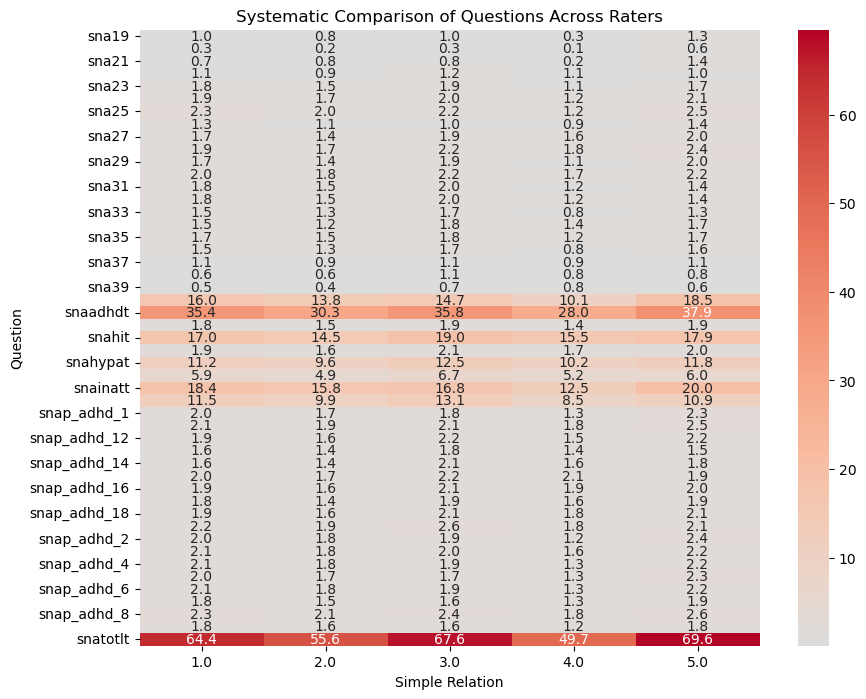

In [213]:


heatmap_data = test_long.pivot_table(
    index="question",  # Rows
    columns=relation_col,  # Columns
    values="Score",  # Values
    aggfunc="mean"  # Aggregation function
)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data, cmap="coolwarm", annot=True, fmt=".1f", cbar=True, center=-0
)
plt.title("Systematic Comparison of Questions Across Raters")
plt.xlabel("Simple Relation")
plt.ylabel("Question")
plt.show()